In [137]:
import sys
!{sys.executable} -m pip install pymongo
!{sys.executable} -m pip install pyyaml
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install isoweek
import os
print(os.getcwd())
# Get Mongo database
from yaml import load
from pymongo import MongoClient
from getsecret import getsecret

client = MongoClient(getsecret("MONGODB_URI"))
db = client[getsecret("DB_NAME")]
ext_client = MongoClient(getsecret("EXT_URI").replace("kovacs","geza"))

ext_db = ext_client[getsecret("DB_NAME")]
# Get all synced accounts and their respective users.
import urllib.request as req
import json
accounts = json.loads(req.urlopen("http://localhost:5000/synced_emails").read().decode("utf-8"))


### CONSTANTS ###
INTENSITY = "intensity"
TOTAL_TIME = "total_time"
ANDROID = "android"
HASH = "email_hash"
GOALS = "goals"
FREQ_GOALS = "freq_goals"
INFREQ_GOALS = "infreq_goals"
OTHER_TIME = "other_time"
FREQ_TIME ="freq_time"
GOAL_TIME = "goal_time"
TARGET_TIME = "target_time"
BROWSER = "browser"
BROWSER_DOMAIN = "browser_domain"
GOAL_TIMES = "goal_frequency_days"
FREQ_GOALS = "freq_goals"
INFREQ_GOALS = "infreq_goals"
BROWSER = "browser"
FREQUENCY = "frequency"
TIME = "time"
GOAL = "goal"
SPEND_LESS_TIME_LENGTH = len("custom/spend_less_time_")
AVG_FREQ_TIME = "avg_freq_time"
AVG_INFREQ_TIME = "avg_infreq_time"
AVG_GOAL_TIME = "avg_goal_time"
UNPRODUCTIVE_TIME = "unproductive_time"
PRODUCTIVE_TIME = "productive_time"
INFREQ_TIME = "infreq_time"
NUM_FREQ_GOALS = "num_freq_goals"
NUM_INFREQ_GOALS = "num_infreq_goals"
import time


### FUNCTIONS ###
# Get freq stats
# week -> goal -> freq
# Top-level-domain-names that are not pertinent to the application.
TLDs = ['aaa', 'abb', 'abc', 'ac', 'aco', 'ad', 'ads', 'ae', 'aeg', 'af', 'afl', 'ag', 'ai', 'aig', 'al', 'am', 'anz', 'ao', 'aol', 'app', 'aq', 'ar', 'art', 'as', 'at', 'au', 'aw', 'aws', 'ax', 'axa', 'az', 'ba', 'bar', 'bb', 'bbc', 'bbt', 'bcg', 'bcn', 'bd', 'be', 'bet', 'bf', 'bg', 'bh', 'bi', 'bid', 'bio', 'biz', 'bj', 'bm', 'bms', 'bmw', 'bn', 'bnl', 'bo', 'bom', 'boo', 'bot', 'box', 'br', 'bs', 'bt', 'buy', 'bv', 'bw', 'by', 'bz', 'bzh', 'ca', 'cab', 'cal', 'cam', 'car', 'cat', 'cba', 'cbn', 'cbs', 'cc', 'cd', 'ceb', 'ceo', 'cf', 'cfa', 'cfd', 'cg', 'ch', 'ci', 'ck', 'cl', 'cm', 'cn', 'co', 'com', 'cr', 'crs', 'csc', 'cu', 'cv', 'cw', 'cx', 'cy', 'cz', 'dad', 'day', 'dds', 'de', 'dev', 'dhl', 'diy', 'dj', 'dk', 'dm', 'dnp', 'do', 'dog', 'dot', 'dtv', 'dvr', 'dz', 'eat', 'ec', 'eco', 'edu', 'ee', 'eg', 'er', 'es', 'esq', 'et', 'eu', 'eus', 'fan', 'fi', 'fit', 'fj', 'fk', 'fly', 'fm', 'fo', 'foo', 'fox', 'fr', 'frl', 'ftr', 'fun', 'fyi', 'ga', 'gal', 'gap', 'gb', 'gd', 'gdn', 'ge', 'gea', 'gf', 'gg', 'gh', 'gi', 'gl', 'gle', 'gm', 'gmo', 'gmx', 'gn', 'goo', 'gop', 'got', 'gov', 'gp', 'gq', 'gr', 'gs', 'gt', 'gu', 'gw', 'gy', 'hbo', 'hiv', 'hk', 'hkt', 'hm', 'hn', 'hot', 'how', 'hr', 'ht', 'hu', 'ibm', 'ice', 'icu', 'id', 'ie', 'ifm', 'il', 'im', 'in', 'inc', 'ing', 'ink', 'int', 'io', 'iq', 'ir', 'is', 'ist', 'it', 'itv', 'jcb', 'jcp', 'je', 'jio', 'jlc', 'jll', 'jm', 'jmp', 'jnj', 'jo', 'jot', 'joy', 'jp', 'ke', 'kfh', 'kg', 'kh', 'ki', 'kia', 'kim', 'km', 'kn', 'kp', 'kpn', 'kr', 'krd', 'kw', 'ky', 'kz', 'la', 'lat', 'law', 'lb', 'lc', 'lds', 'li', 'lk', 'llc', 'lol', 'lpl', 'lr', 'ls', 'lt', 'ltd', 'lu', 'lv', 'ly', 'ma', 'man', 'map', 'mba', 'mc', 'md', 'me', 'med', 'men', 'mg', 'mh', 'mil', 'mit', 'mk', 'ml', 'mlb', 'mls', 'mm', 'mma', 'mn', 'mo', 'moe', 'moi', 'mom', 'mov', 'mp', 'mq', 'mr', 'ms', 'msd', 'mt', 'mtn', 'mtr', 'mu', 'mv', 'mw', 'mx', 'my', 'mz', 'na', 'nab', 'nba', 'nc', 'ne', 'nec', 'net', 'new', 'nf', 'nfl', 'ng', 'ngo', 'nhk', 'ni', 'nl', 'no', 'now', 'np', 'nr', 'nra', 'nrw', 'ntt', 'nu', 'nyc', 'nz', 'obi', 'off', 'om', 'one', 'ong', 'onl', 'ooo', 'org', 'ott', 'ovh', 'pa', 'pay', 'pe', 'pet', 'pf', 'pg', 'ph', 'phd', 'pid', 'pin', 'pk', 'pl', 'pm', 'pn', 'pnc', 'pr', 'pro', 'pru', 'ps', 'pt', 'pub', 'pw', 'pwc', 'py', 'qa', 'qvc', 're', 'red', 'ren', 'ril', 'rio', 'rip', 'ro', 'rs', 'ru', 'run', 'rw', 'rwe', 'sa', 'sap', 'sas', 'sb', 'sbi', 'sbs', 'sc', 'sca', 'scb', 'sd', 'se', 'ses', 'sew', 'sex', 'sfr', 'sg', 'sh', 'si', 'sj', 'sk', 'ski', 'sky', 'sl', 'sm', 'sn', 'so', 'soy', 'sr', 'srl', 'srt', 'st', 'stc', 'su', 'sv', 'sx', 'sy', 'sz', 'tab', 'tax', 'tc', 'tci', 'td', 'tdk', 'tel', 'tf', 'tg', 'th', 'thd', 'tj', 'tjx', 'tk', 'tl', 'tm', 'tn', 'to', 'top', 'tr', 'trv', 'tt', 'tui', 'tv', 'tvs', 'tw', 'tz', 'ua', 'ubs', 'ug', 'uk', 'uno', 'uol', 'ups', 'us', 'uy', 'uz', 'va', 'vc', 've', 'vet', 'vg', 'vi', 'vig', 'vin', 'vip', 'vn', 'vu', 'wed', 'wf', 'win', 'wme', 'wow', 'ws', 'wtc', 'wtf', 'xin', 'xxx', 'xyz', 'ye', 'you', 'yt', 'yun', 'za', 'zip', 'zm', 'zw']
def get_name(name, device):
    """
    @param name: goal name (package name for Android)
    @param device: "android" or "browser" or "browser_domain"
    @return name of goal with subdomains removed and goal annotation removed (i.e. spend_less_time)
    """
    if device == ANDROID  and name =="com.google.android.gm" or device == BROWSER and "gmail" in name:
        return "gmail"
    name = name.lower()
    if "custom" in name and device == BROWSER:
        # strip off the "custom/spend_less_time_"
        name = name[SPEND_LESS_TIME_LENGTH:]
    elif device == BROWSER:
        return name.split('/spend')[0]
    # Now we have to get juicy part of domain.
    subs = list(filter(lambda x: x != "android" and x != "google" and x != "apps" and x not in TLDs, name.split('.')))
    if device == ANDROID: 
        if len(subs) > 0:
            return subs[0]
        return name
    else:
        if len(subs) > 0:
            return subs[len(subs) - 1]    
        
def get_freq_stats(user):
    """
    Gets the frequency stats for browser.
    :param user user id 
    :return {week: {FREQ_GOALS: set(), INFREQ_GOALS: set()}}
    """
    stat = {}
    for setting in ext_db[user + "_synced:goal_frequencies"].find():
        val = json.loads(setting["val"])
        if val["algorithm"] == "isoweek_random":
            isoWeek = int(datetime.fromtimestamp(setting["timestamp_local"]/1000 + 8 * (60 ** 2)).isocalendar()[1])
            currentIsoWeek = int(datetime.fromtimestamp(time.time()).isocalendar()[1])
            for week in range(isoWeek, currentIsoWeek + 1):
                if str(week) not in stat:
                    stat[str(week)] = {FREQ_GOALS: set([]), INFREQ_GOALS: set([])}
                if val["onweeks"][week] == 1:
                    stat[str(week)][FREQ_GOALS].add(get_name(setting["key"], BROWSER))
                else:
                    stat[str(week)][INFREQ_GOALS].add(get_name(setting["key"], BROWSER))
    return stat


/Users/drewgregory/JupyterNotebooks/habitlab-data-analysis


num_freq_goals


In [2]:
%load_ext rpy2.ipython

In [58]:
# Now, let's get the mapping from productive apps to unproductive ones.
from statistics import mode, median
name_to_prod = {}
with open('domain_to_productivity.json', 'r') as f:
    domain_to_prod = json.load(f)
    for domain in domain_to_prod:
        name = get_name(domain, BROWSER_DOMAIN)
        if name not in name_to_prod: 
            name_to_prod[name] = []
        name_to_prod[name].append(domain_to_prod[domain])
for name in name_to_prod:
    try:
        name_to_prod[name] = mode(name_to_prod[name])
    except StatisticsError:
        name_to_prod[name] = median(name_to_prod[name])

In [68]:
# Now, for each day, get frequency intensity
day_stats = []
import math
import moment
for account in accounts:
    curr_date = ""
    day_data = {PRODUCTIVE_TIME: 0, UNPRODUCTIVE_TIME: 0,INTENSITY: 0, INFREQ_GOALS: set([]), TARGET_TIME:0,
                FREQ_TIME: 0, TOTAL_TIME: 0, GOAL_TIME: 0, HASH: account["_id"], GOALS: set([]), 
                FREQ_GOALS: set([]), OTHER_TIME: 0 }
    for user in account[ANDROID]:
        for s in db[user+ "_sessions"].find({"enabled": {"$exists": True}, "timestamp": {"$lt": 1535233198480}, "duration": {"$lt": 86400}}):
            time = moment.unix(s["timestamp"])
            date = time.format("YYYY-MM-DD")
            if date != curr_date:
                if curr_date != "" and day_data[TOTAL_TIME] > 0 and len(day_data[GOALS]) > 0 and day_data[GOAL_TIME] > 0 and day_data[OTHER_TIME] > 0:
                    # Add obj and reset data
                    # take logs of time cuz time is log-norm distributed
                    # Have a more clever way of determining intensity: the % time spent on freq goals
                    for key in day_data:
                        if "time" in key and day_data[key] > 0:
                            day_data[key]= math.log(day_data[key])
                    day_stats.append(day_data)
                    day_data = {PRODUCTIVE_TIME: 0, UNPRODUCTIVE_TIME: 0,INTENSITY: 0, INFREQ_GOALS: set([]), TARGET_TIME:0,
                                FREQ_TIME: 0, TOTAL_TIME: 0, GOAL_TIME: 0, HASH: account["_id"], GOALS: set([]), 
                                FREQ_GOALS: set([]), OTHER_TIME: 0 }
                curr_date = date
            if "enabled" in s:
                if s["enabled"]:
                    day_data[GOALS].add(s["domain"])
                    if s["duration"] > 0:
                        if s["domain"] + "_domain_time" not in day_data:
                            day_data[s["domain"]+"_domain_time"] = 0
                        day_data[s["domain"]+"_domain_time"] += s["duration"]
                    if "frequent" in s and s["frequent"]:
                        day_data[FREQ_TIME] += s["duration"]
                        day_data[FREQ_GOALS].add(s["domain"])
                    elif "frequent" in s:
                        day_data[INFREQ_GOALS].add(s["domain"])
                    day_data[GOAL_TIME] += s["duration"]
                elif "target" in s and s["target"]:
                    day_data[TARGET_TIME] += s["duration"]                        
                else:
                    day_data[OTHER_TIME] += s["duration"]
            name = get_name(s["domain"], ANDROID)
            if name in name_to_prod:
                if name_to_prod[name] > 0:
                    day_data[PRODUCTIVE_TIME] += s["duration"]
                elif name_to_prod[name] < 0:
                    day_data[UNPRODUCTIVE_TIME] += s["duration"]
            day_data[TOTAL_TIME] += (s["duration"])
            

(array([447., 485., 424., 315., 235., 173., 105.,  92.,  69.,  60.,  45.,
         36.,  32.,  23.,  26.,  19.,  31.,  20.,   1.,   2.]),
 array([4.500000e+01, 5.020550e+03, 9.996100e+03, 1.497165e+04,
        1.994720e+04, 2.492275e+04, 2.989830e+04, 3.487385e+04,
        3.984940e+04, 4.482495e+04, 4.980050e+04, 5.477605e+04,
        5.975160e+04, 6.472715e+04, 6.970270e+04, 7.467825e+04,
        7.965380e+04, 8.462935e+04, 8.960490e+04, 9.458045e+04,
        9.955600e+04]),
 <a list of 20 Patch objects>)

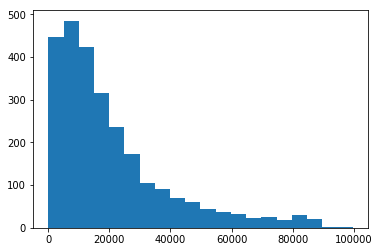

In [69]:
import matplotlib.pyplot as pyplot
pyplot.figure(12)
pyplot.hist([math.exp(day[TOTAL_TIME]) for day in day_stats if math.exp(day[TOTAL_TIME])], bins=20)

In [127]:
import pandas as pd
data_frame_dict = { key: [] for key in day_stats[0] if "domain_time" not in key}

data_frame_dict[AVG_GOAL_TIME] = []
data_frame_dict[AVG_FREQ_TIME] = []
data_frame_dict[AVG_INFREQ_TIME] = []
# Let's also count up the freq to see if they're roughly equal
field_stats = {}
for item in day_stats:
    if len(item[FREQ_GOALS]) > 0 and item[FREQ_TIME] != item[GOAL_TIME]:
        for key in item:

            if "domain_time" not in key:
                if key == INTENSITY:
                    data_frame_dict[key].append(len(item[FREQ_GOALS])/len(item[GOALS]))
                    #data_frame_dict[key].append(1-math.exp(item[FREQ_TIME])/math.exp(item[TOTAL_TIME]))
                else:
                    data_frame_dict[key].append((item[key]))
        data_frame_dict[AVG_GOAL_TIME].append(item[GOAL_TIME]/len(item[GOALS]))
        data_frame_dict[AVG_FREQ_TIME].append(item[FREQ_TIME]/len(item[FREQ_GOALS]))
        data_frame_dict[AVG_INFREQ_TIME].append(math.log(math.exp(item[GOAL_TIME])-math.exp(item[FREQ_TIME]))/len(item[INFREQ_GOALS]))
        
df = pd.DataFrame(data_frame_dict)
print(df)


mean([len(item[GOALS]) for item in day_stats])
df.to_csv('effect_freq_time_spent_2018_8_31.csv')

      productive_time  unproductive_time  intensity  \
0            7.313220           0.000000   0.333333   
1            4.430817           3.044522   0.500000   
2            5.541264           7.882692   0.333333   
3            5.899897           7.902857   0.666667   
4            5.680173           8.218787   0.666667   
5            6.274762           8.939974   0.800000   
6            4.859812           8.122371   0.250000   
7            7.121252           7.741968   0.333333   
8            6.720220           8.000685   0.500000   
9            5.356586           6.150603   0.500000   
10           4.418841           9.062188   0.200000   
11           4.663439           9.302828   0.800000   
12           0.000000           2.302585   0.500000   
13           7.604894           9.117567   0.250000   
14           4.770685           9.080573   0.250000   
15           0.000000           9.124891   0.250000   
16           0.000000          10.020070   0.200000   
17        

In [109]:
%%R -i df -w 5 -h 5 --units in -r 200
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(avg_freq_time ~ intensity + (1|email_hash), data = df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: avg_freq_time ~ intensity + (1 | email_hash)
   Data: df

REML criterion at convergence: 6948.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9320 -0.5140 -0.0991  0.3997  4.2082 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 1.429    1.196   
 Residual               1.414    1.189   
Number of obs: 1983, groups:  email_hash, 409

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)    6.3352     0.1178 1498.8777   53.79   <2e-16 ***
intensity     -5.3136     0.1826 1927.0714  -29.10   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.813


In [108]:
%%R -i df -w 5 -h 5 --units in -r 200
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(avg_infreq_time ~ intensity + (1|email_hash), data = df)
summary(results)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "infreq_goals". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'set'>'
  (name, str(e)))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "goals". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'set'>'
  (name, str(e)))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "freq_goals". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'set'>'
  (name, str(e)))


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: avg_infreq_time ~ intensity + (1 | email_hash)
   Data: df

REML criterion at convergence: 7337.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2143 -0.5072 -0.0902  0.4307  4.4735 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 1.457    1.207   
 Residual               1.775    1.332   
Number of obs: 1983, groups:  email_hash, 409

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)    1.3212     0.1277 1528.1781   10.35   <2e-16 ***
intensity      4.6147     0.2023 1950.5064   22.81   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.831


In [128]:
%%R -i df -w 5 -h 5 --units in -r 200
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(unproductive_time ~ intensity + (1|email_hash), data = df)
summary(results)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "infreq_goals". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'set'>'
  (name, str(e)))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "goals". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'set'>'
  (name, str(e)))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "freq_goals". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'set'>'
  (name, str(e)))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/r

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: unproductive_time ~ intensity + (1 | email_hash)
   Data: df

REML criterion at convergence: 6896.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.6368 -0.3673  0.1196  0.4919  3.9011 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 1.889    1.374   
 Residual               1.300    1.140   
Number of obs: 1983, groups:  email_hash, 409

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)    7.8410     0.1204 1354.7862  65.123   <2e-16 ***
intensity      0.2524     0.1781 1863.8919   1.418    0.156    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.775


In [72]:
%%R -i df -w 5 -h 5 --units in -r 200
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(avg_infreq_time ~ avg_freq_time + (1|email_hash), data = df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: avg_infreq_time ~ avg_freq_time + (1 | email_hash)
   Data: df

REML criterion at convergence: 7802.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4828 -0.5687 -0.1842  0.4014  3.9551 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 1.689    1.300   
 Residual               2.272    1.507   
Number of obs: 1983, groups:  email_hash, 409

Fixed effects:
               Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   3.725e+00  1.134e-01 9.832e+02  32.848   <2e-16 ***
avg_freq_time 3.354e-03  2.332e-02 1.979e+03   0.144    0.886    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
avg_freq_tm -0.729


In [73]:
%%R -i df -w 5 -h 5 --units in -r 200

#install.packages('ez')
#install.packages('lme4')

library(lme4)
library(sjPlot)
library(lmerTest)
#library(ez)

In [74]:
%%R -i df -w 5 -h 5 --units in -r 200
# Does total time spent per day on phone change depending on percentage
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(total_time ~ intensity + (1|email_hash), data = df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: total_time ~ intensity + (1 | email_hash)
   Data: df

REML criterion at convergence: 4967.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.5764 -0.4217  0.1268  0.5542  3.1641 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 0.4609   0.6789  
 Residual               0.5326   0.7298  
Number of obs: 1983, groups:  email_hash, 409

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)    9.3326     0.0705 1471.2026 132.374   <2e-16 ***
intensity      0.2403     0.1112 1939.7321   2.162   0.0307 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.826


In [75]:
%%R -i df -w 5 -h 5 --units in -r 200
# Does goal time spent per day on phone change depending on percentage
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(goal_time ~ intensity + (1|email_hash), data = df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: goal_time ~ intensity + (1 | email_hash)
   Data: df

REML criterion at convergence: 5534.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.5246 -0.4306  0.1388  0.5622  4.4775 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 0.5663   0.7525  
 Residual               0.7188   0.8478  
Number of obs: 1983, groups:  email_hash, 409

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)    8.31635    0.08073 1465.06947 103.008   <2e-16 ***
intensity     -0.02363    0.12848 1949.21265  -0.184    0.854    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.834


In [76]:
%%R -i df -w 5 -h 5 --units in -r 200
# Does non-goal time spent per day on phone change depending on percentage
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(other_time ~ intensity + (1|email_hash), data = df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: other_time ~ intensity + (1 | email_hash)
   Data: df

REML criterion at convergence: 5908.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.3029 -0.4298  0.1029  0.5601  2.5094 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 1.0030   1.0015  
 Residual               0.8108   0.9004  
Number of obs: 1983, groups:  email_hash, 409

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 8.523e+00  9.231e-02 1.410e+03  92.324   <2e-16 ***
intensity   3.413e-01  1.396e-01 1.891e+03   2.445   0.0146 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.793


In [77]:
%%R -i df -w 5 -h 5 --units in -r 200
# Does goal time spent per day on phone change depending on percentage
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(target_time ~ intensity + (1|email_hash), data = df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: target_time ~ intensity + (1 | email_hash)
   Data: df

REML criterion at convergence: 6932.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0210 -0.1409 -0.0783 -0.0291  7.1528 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 1.224    1.106   
 Residual               1.439    1.200   
Number of obs: 1983, groups:  email_hash, 409

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)   
(Intercept)    0.3417     0.1156 1470.0811   2.957  0.00316 **
intensity      0.3029     0.1826 1941.5177   1.659  0.09722 . 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.828


In [78]:
%%R -i df -w 5 -h 5 --units in -r 200
# Does goal time spent per day on phone change depending on percentage
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(avg_goal_time ~ intensity + (1|email_hash), data = df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: avg_goal_time ~ intensity + (1 | email_hash)
   Data: df

REML criterion at convergence: 3984.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3097 -0.4875 -0.1261  0.3584  6.8678 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 0.4882   0.6987  
 Residual               0.2921   0.5404  
Number of obs: 1983, groups:  email_hash, 409

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 1.865e+00  5.864e-02 1.344e+03  31.807  < 2e-16 ***
intensity   2.763e-01  8.488e-02 1.852e+03   3.255  0.00115 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.759


f653fba473726066017d092faf775b60a39bd4616590332eb815f0bb74fa22f2


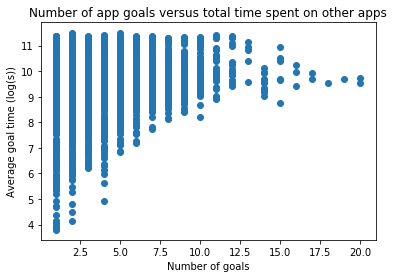

In [105]:
import matplotlib.pyplot as pyplot
import collections

most_active_users = {"": 0}
most_active_user = ""
for stat in day_stats:
    email = stat[HASH]
    if email not in most_active_users:
        most_active_users[email] = 0
    most_active_users[email] += 1
    if most_active_users[email] > most_active_users[most_active_user]:
        most_active_user = email
print(most_active_user)
pyplot.figure(43)
pyplot.title("Number of app goals versus total time spent on other apps")
pyplot.ylabel("Average goal time (log(s))")
pyplot.xlabel("Number of goals")
pyplot.scatter([len(stat[GOALS]) for stat in day_stats], [(stat[TOTAL_TIME]) for stat in day_stats])


In [98]:
%%R -i df -w 5 -h 5 --units in -r 200
# Does non-goal time spent per day on phone inversely depend on goal-time?
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(other_time ~ avg_goal_time + (1|email_hash), data = df)
summary(results)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "infreq_goals". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'set'>'
  (name, str(e)))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "goals". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'set'>'
  (name, str(e)))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "freq_goals". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'set'>'
  (name, str(e)))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/r

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: other_time ~ avg_goal_time + (1 | email_hash)
   Data: df

REML criterion at convergence: 5915

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.1974 -0.4304  0.0999  0.5456  2.5575 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 1.0104   1.0052  
 Residual               0.8113   0.9007  
Number of obs: 1983, groups:  email_hash, 409

Fixed effects:
                Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)      8.81728    0.09226 1132.42437  95.569   <2e-16 ***
avg_goal_time   -0.05779    0.03637 1960.28745  -1.589    0.112    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
avg_goal_tm -0.791


In [99]:
%%R -i df -w 5 -h 5 --units in -r 200
# Does goal time spent per day on phone change depending on percentage
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(target_time ~ avg_goal_time + (1|email_hash), data = df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: target_time ~ avg_goal_time + (1 | email_hash)
   Data: df

REML criterion at convergence: 6931.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9699 -0.1499 -0.0669 -0.0212  7.1203 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 1.273    1.128   
 Residual               1.427    1.195   
Number of obs: 1983, groups:  email_hash, 409

Fixed effects:
               Estimate Std. Error        df t value Pr(>|t|)  
(Intercept)   2.722e-01  1.142e-01 1.066e+03   2.384   0.0173 *
avg_goal_time 1.144e-01  4.662e-02 1.867e+03   2.454   0.0142 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
avg_goal_tm -0.817


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: other_time ~ avg_goal_time + (1 | email_hash)
   Data: df

REML criterion at convergence: 5915

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.1974 -0.4304  0.0999  0.5456  2.5575 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 1.0104   1.0052  
 Residual               0.8113   0.9007  
Number of obs: 1983, groups:  email_hash, 409

Fixed effects:
                Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)      8.81728    0.09226 1132.42437  95.569   <2e-16 ***
avg_goal_time   -0.05779    0.03637 1960.28745  -1.589    0.112    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
avg_goal_tm -0.791


In [101]:
# see average change for time spent in goals vs. outside of goal when freq setting changes
from statistics import mean, StatisticsError
goal_time_change_stats = []
other_time_change_stats = []
user_stats = {}
max_time = 0
for day in day_stats:
    email = day[HASH]
    if day[HASH] not in user_stats:
        user_stats[email] = {FREQ_GOALS: set([]), INFREQ_GOALS: set([])}
    user_stats[email][FREQ_GOALS] = user_stats[email][FREQ_GOALS].union(day[FREQ_GOALS])
    user_stats[email][INFREQ_GOALS] = user_stats[email][INFREQ_GOALS].union(day[INFREQ_GOALS])
    for domain_time in day:
        if "_domain_time" in domain_time:
            domain = domain_time[:-len("_domain_time")]
            if domain not in user_stats[email]:
                user_stats[email][domain] = {"frequent_goal": [], "infrequent_goal": [], "frequent_other": [], "infrequent_other": []}
            if not (domain in day[FREQ_GOALS] and domain in day[INFREQ_GOALS]):
                freq = "frequent" if domain in day[FREQ_GOALS] else "infrequent"
                if day[domain_time] > max_time:
                    max_time = day[domain_time]
                    print(max_time)
                user_stats[email][domain][freq + "_goal"].append(day[domain_time])
                user_stats[email][domain][freq+"_other"].append(day[TOTAL_TIME] - day[domain_time])
for user in user_stats:
    for domain in user_stats[user][FREQ_GOALS].intersection(user_stats[user][INFREQ_GOALS]):
        if 0 not in user_stats[user][domain]["frequent_goal"] and 0 not in user_stats[user][domain]["infrequent_goal"]:
            try:
                mean_freq_goal = mean(user_stats[user][domain]["frequent_goal"])
                # print("frequent" + str(user_stats[user][domain]["frequent_goal"]))
                # print("infrequent  " + str(user_stats[user][domain]["infrequent_goal"]))
                goal_change = mean_freq_goal - mean(user_stats[user][domain]["infrequent_goal"])
                other_change = mean(user_stats[user][domain]["frequent_other"]) - mean(user_stats[user][domain]["infrequent_other"])
                goal_time_change_stats.append(goal_change)
                other_time_change_stats.append(other_change)
            except StatisticsError:
                pass

4.3694478524670215
8.339739766019143
8.733594061863055
9.11679862756782
9.914625296946584
10.663124474364906
11.05668271897453
11.340082840810044


In [102]:
# our next data set: goal_time, freq, goal, and email_hash
goal_stats_dict = {"app": [], "email": [], "time": [], "other_time": [], "frequency": []}
for day in day_stats:
    for key in day:
        if "domain_time" in key:
            domain = key[:-len("_domain_time")]
            if not (domain in day[FREQ_GOALS] and domain in day[INFREQ_GOALS]) and (domain in day[FREQ_GOALS] or domain in day[INFREQ_GOALS]):
                freq = "frequent" if domain in day[FREQ_GOALS] else "infrequent"
                goal_stats_dict["app"].append(domain)
                goal_stats_dict["email"].append(day[HASH])
                goal_stats_dict["time"].append(day[key])
                goal_stats_dict["other_time"].append(day[GOAL_TIME] - day[key])
                goal_stats_dict["frequency"].append(freq)
goal_freq_df = pd.DataFrame(goal_stats_dict)
goal_freq_df.to_csv("goal_freq_df.csv")

In [103]:
%%R -i goal_freq_df -w 5 -h 5 --units in -r 200
# Does non-goal time spent per day on phone inversely depend on goal-time?
goal_freq_df$email <- factor(goal_freq_df$email,  ordered=FALSE)
goal_freq_df$app <- factor(goal_freq_df$app, ordered=FALSE)
goal_freq_df$frequency <- factor(goal_freq_df$frequency, levels=c("infrequent", "frequent"))
results <- lmer(time ~ frequency + (1|email) + (1|app), data = goal_freq_df)
summary(results)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: time ~ frequency + (1 | email) + (1 | app)
   Data: goal_freq_df

REML criterion at convergence: 45541.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2329 -0.5522  0.1284  0.6726  3.8188 

Random effects:
 Groups   Name        Variance Std.Dev.
 app      (Intercept) 1.8316   1.3534  
 email    (Intercept) 0.4101   0.6404  
 Residual             2.6027   1.6133  
Number of obs: 11641, groups:  app, 581; email, 461

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)        5.103e+00  8.060e-02  7.114e+02  63.310  < 2e-16 ***
frequencyfrequent -1.070e-01  3.263e-02  1.156e+04  -3.279  0.00104 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
frqncyfrqnt -0.197


608
0.5016447368421053
[-0.035402246805802, 0.02874938046150202]


<BarContainer object of 2 artists>

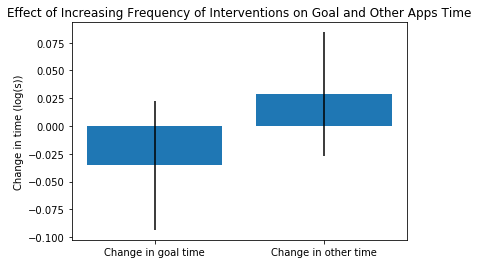

In [104]:
from scipy.stats import sem
pyplot.figure(32)
print(len(goal_time_change_stats))
pyplot.title("Effect of Increasing Frequency of Interventions on Goal and Other Apps Time")
pyplot.ylabel('Change in time (log(s))')
print(len([stat for stat in other_time_change_stats if stat > 0])/len(goal_time_change_stats))
print([mean(goal_time_change_stats), mean(other_time_change_stats)])
pyplot.bar(["Change in goal time", "Change in other time"], [mean(goal_time_change_stats), mean(other_time_change_stats)] , .8, yerr=[sem(goal_time_change_stats), sem(other_time_change_stats)])

In [21]:
print()

In [27]:
# Get all browser user ids that have goal frequencies collection.
print ("getting collection names")
collection_names = ext_db.list_collection_names()
print("got collection names")
browser_user_ids = []
counter = 0
for name in collection_names:
    if counter % 100000 == 0:
        print(counter)
    counter += 1
    if "goal_frequencies" in name:
        browser_user_ids.append(name[:-len("_synced:goal_frequencies")])

getting collection names
got collection names
0
100000
200000


In [28]:
print(browser_user_ids)

['c8d66c0d7b3573ad940047e7', '883c1ba5c4e5472d2f8067d6', 'd49e6ce9c7fadc10f3baf7bd', '601ef212e501d1cdccebf63b', '9e63d7e9d250c795b9c657e8', 'ca55f0a0e2e0765089529619', '70f7e2720c2ff541f5f6d774', '9aa2418cff3facda9bb90c15', 'f180aced4b5d40760f41d2b1', 'a09f4d8b6326097b44238b62', '1ac8e0729bdbcff844ba9739', '126dcab7446cd026ebd53a10', '6afba4b9d880466f13ce5053', '738436695cad09ae1d5cc170', '20b1bb4bd46607262f4ce3b2', 'e64bf235da9a0a1346c1ecc7', '60df2e411b71f7b62be41010', '6516b06cb55ec78854c1d70b', 'e0ea71583ed30617dda9659c', '2544f0af4ea573a513473ddf', '051033200328aa7edcf3b296', '719d24446db13c3224d747d3', '326146364c9e6fe04456f8c0', '97e3ba57fb88a97b78e91b9d', 'e0b1e191d3d16a85569cdf28', '1e3246d0e884b3b777e612c5', '699985170c49bffd2b28061c', '0dc64ed10ae9d06eb6663054', 'c7d6cedca58512bd8c27fe15', '7abac377472cb1a76b196161', '97abe76eb8708c3c3d9a688c', '055bdc7d333c545546f4e555', '7de231e89272243eef3728c9', '00e8b1a310d478e0415d0c2e', '82235603d3c577a64274cbb1', '38cde5ccd8c7a6d7a3

In [143]:

browser_days = []
import moment
import math
from time_utils import epoch_to_date
from datetime import datetime
# Now the browser side of things!!
for user in browser_user_ids:
    # Get freq settings:
    user_stats = get_freq_stats(user)
    if len(user_stats) == 0:
        continue
    browser_day_map = {}
    for day_stat in ext_db[user+ "_synced:seconds_on_domain_per_day"].find({"key2":{"$gt": 930}}):
        # The key1 serves as a day. However, if we are going to compare same day stuffs for android.
        # We need to instead build day string from moment
        day = epoch_to_date(int(day_stat['key2']))
        if day not in browser_day_map:
            browser_day_map[day] = {}
        goal = get_name(day_stat['key'], BROWSER_DOMAIN)
        if goal:
            if goal + "_domain_time" not in browser_day_map or day_stat["val"] > browser_day_map[goal + "_domain_time"]:
                browser_day_map[day][goal + "_domain_time"] = day_stat["val"]
    for day in browser_day_map:
        day_data = { FREQ_TIME: 0, INFREQ_TIME: 0, INTENSITY: 0, INFREQ_GOALS: set([]),  TOTAL_TIME: 0, GOAL_TIME: 0, HASH:user, GOALS: set([]), FREQ_GOALS: set([]), OTHER_TIME: 0, GOAL_TIMES: []}
        # weirdly enough, datetime timestamps are seconds, not ms.
        isoWeek = str(datetime.fromtimestamp(moment.date(day).epoch() + 8 * (60 ** 2)).isocalendar()[1])
        # Add obj and reset data
        # take logs of time cuz time is log-norm distributed
        # First, count up all domain_times into TOTAL, GOAL, and OTHER
        if isoWeek not in user_stats:
            continue
        print(user_stats[isoWeek][FREQ_GOALS])
        day_data[FREQ_GOALS] = user_stats[isoWeek][FREQ_GOALS]
        day_data[INFREQ_GOALS] = user_stats[isoWeek][INFREQ_GOALS]
        day_data[GOALS] = day_data[FREQ_GOALS].union(day_data[INFREQ_GOALS])
        if len(user_stats[isoWeek][FREQ_GOALS].intersection(user_stats[isoWeek][INFREQ_GOALS])) > 0:
            continue
        for key in browser_day_map[day]:
            if "_domain_time" in key:
                key_goal = key[:-len("_domain_time")]
                day_data[TOTAL_TIME] += int(browser_day_map[day][key])
                if key_goal in day_data[FREQ_GOALS] or key_goal in day_data[INFREQ_GOALS]:
                    frequent = "frequent" if key_goal in day_data[FREQ_GOALS] else "infrequent"
                    if key_goal in day_data[FREQ_GOALS]:
                        day_data[FREQ_TIME] += browser_day_map[day][key]
                    else:
                        day_data[INFREQ_TIME] += browser_day_map[day][key]
                    day_data[GOAL_TIMES].append({"frequency": frequent, "goal": key_goal, "time": browser_day_map[day][key]})
                    day_data[GOAL_TIME] += browser_day_map[day][key]
                else:
                    day_data[OTHER_TIME] += browser_day_map[day][key]
        for key in day_data:
            if "time" in key and day_data[key] > 0:
                day_data[key]= math.log(day_data[key])
        if len(day_data[FREQ_GOALS]) > 0 and len(day_data[INFREQ_GOALS]) > 0:
            day_data[AVG_FREQ_TIME] = day_data[FREQ_TIME]/len(day_data[FREQ_GOALS])
            day_data[AVG_INFREQ_TIME] = day_data[INFREQ_TIME]/len(day_data[INFREQ_GOALS])
            for goal_time in day_data[GOAL_TIMES]:
                    if goal_time[TIME] > 0:
                        goal_time[TIME] = math.log(goal_time[TIME])
            if len(day_data[FREQ_GOALS])+ len(day_data[INFREQ_GOALS]) > 0:
                day_data[INTENSITY] = len(day_data[FREQ_GOALS])/(len(day_data[FREQ_GOALS])+ len(day_data[INFREQ_GOALS]))
                browser_days.append(day_data)



{'washingtonpost', 'ebay', 'facebook'}
{'washingtonpost', 'ebay', 'facebook'}
{'washingtonpost', 'ebay', 'facebook'}
{'washingtonpost', 'ebay', 'facebook'}
{'washingtonpost', 'ebay', 'facebook'}
{'washingtonpost', 'ebay', 'facebook'}
{'washingtonpost', 'ebay', 'facebook'}
{'facebook'}
{'youtube', 'gmail', 'facebook'}
{'facebook'}
{'facebook'}
{'gmail', 'www', 'youtube', 'twitter'}
{'gmail', 'www', 'youtube', 'twitter'}
{'gmail', 'www', 'youtube', 'twitter'}
set()
set()
set()
set()
set()
set()
set()
{'twitter'}
{'twitter'}
{'youtube', 'reddit'}
{'youtube', 'reddit'}
{'youtube', 'reddit'}
{'youtube', 'reddit'}
set()
set()
set()
set()
set()
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook', 'twitter'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube'}
{'youtube', 'facebook'}
{'youtube'}
set()
set()
set()
set()
set()
{'whatsapp'}
{'whatsapp'}
{'whatsapp'}
{'whatsapp'}
{'whatsapp'}
{'whatsapp'}
{'facebook'}
{'gumtree', 'youtube'}
{'gumtree', 'youtube'}
{'gu

set()
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook', 'fiscaaltotaal', 'www'}
{'fiscaalgemak', 'youtube', 'www'}
{'fiscaalgemak', 'youtube', 'www'}
{'fiscaalgemak', 'youtube', 'www'}
{'fiscaalgemak', 'youtube', 'www'}
{'fiscaalgemak', 'youtube', 'www'}
{'fiscaalgemak'}
{'fiscaalgemak'}
{'fiscaalgemak'}
{'facebook', 'armorgames'}
{'facebook', 'armorgames'}
{'facebook', 'armorgames'}
{'facebook', 'armorgames'}
{'facebook', 'armorgames'}
{'youtube', 'armorgames', 'reddit'}
{'youtube', 'armorgames', 'reddit'}
{'youtube', 'armorgames', 'reddit'}
{'youtube', 'armorgames', 'reddit'}
{'youtube', 'armorgames', 'reddit'}
{'youtube', 'armorgames', 'reddit'}
{'youtube', 'armorgames'}
{'youtube', 'armorgames'}
{'youtube', 'armorgames'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'youtube'}
{'youtube'}
{'facebook', 'origo'}
{'youtube', 'facebook', 'ori

{'gamek', 'reddit', 'twitter', 'twitch', 'genk'}
{'gamek', 'reddit', 'twitter', 'twitch', 'genk'}
{'gamek', 'reddit', 'twitter', 'twitch', 'genk'}
{'gamek', 'reddit', 'twitter', 'twitch', 'genk'}
{'gamek', 'reddit', 'twitter', 'twitch', 'genk'}
{'gamek', 'reddit', 'twitter', 'twitch', 'genk'}
{'gamek', 'reddit', 'twitter', 'twitch', 'genk'}
{'gamek', 'genk', 'quora', 'reddit'}
{'gamek', 'genk', 'quora', 'reddit'}
{'gamek', 'genk', 'quora', 'reddit'}
{'gamek', 'genk', 'quora', 'reddit'}
{'gamek', 'genk', 'quora', 'reddit'}
{'gamek', 'genk', 'quora', 'reddit'}
{'gamek', 'genk', 'quora', 'reddit'}
{'twitch', 'youtube', 'reddit', 'cafebiz'}
{'twitch', 'youtube', 'reddit', 'cafebiz'}
{'twitch', 'youtube', 'reddit', 'cafebiz'}
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
{'facebook', 'buzzfeed'}
{'facebook', 'buzzfeed'}
{'facebook', 'buzzfeed'}
{'facebook', 'buzzfeed'}
{'facebook', 'buzzfeed'}
{'facebook', 'buzzfeed'}
{'facebook', 'buzzfeed'}
{'facebook

{'slashdot', 'twitter', 'buzzfeed', 'youtube', 'slack', 'facebook'}
{'slashdot', 'twitter', 'buzzfeed', 'youtube', 'slack', 'facebook'}
{'slashdot', 'twitter', 'buzzfeed', 'youtube', 'slack', 'facebook'}
{'slashdot', 'twitter', 'buzzfeed', 'youtube', 'slack', 'facebook'}
{'slashdot', 'twitter', 'buzzfeed', 'youtube', 'slack', 'facebook'}
{'slashdot', 'twitter', 'buzzfeed', 'youtube', 'slack', 'facebook'}
{'reddit', 'twitter', 'youtube', 'slack', 'facebook', 'ycombinator'}
{'reddit', 'twitter', 'youtube', 'slack', 'facebook', 'ycombinator'}
{'reddit', 'twitter', 'youtube', 'slack', 'facebook', 'ycombinator'}
{'reddit', 'twitter', 'youtube', 'slack', 'facebook', 'ycombinator'}
{'reddit', 'twitter', 'youtube', 'slack', 'facebook', 'ycombinator'}
{'slashdot', 'amazon', 'twitter', 'youtube', 'slack', 'ycombinator', 'facebook'}
{'reddit', 'twitter', 'youtube', 'slack', 'facebook', 'ycombinator'}
{'slashdot', 'amazon', 'twitter', 'youtube', 'slack', 'ycombinator', 'facebook'}
{'slashdot', 'am

{'twitter'}
{'twitter'}
{'twitter'}
{'twitter'}
{'twitter'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'youtube'}
{'youtube'}
set()
set()
set()
set()
set()
set()
set()
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'facebook'}
{'facebook'}
{'facebook'}
{'youtube', 'facebook', 'linkedin'}
{'youtube', 'facebook', 'linkedin'}
{'facebook'}
{'facebook'}
{'facebook'}
{'amazon'}
{'amazon'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'kongregate', 'gmail', '9gag'}
{'kongregate', 'gmail', '9gag'}
{'kongregate', 'gmail', '9gag'}
{'kongregate', 'gmail', '9gag'}
{'kongregate', 'youtube', '9gag', 'facebook'}
{'kongregate', 'youtube', '9gag', 'facebook'}
{'kongregate', 'youtube', '9gag', 'facebook'}
set()
set()
set()
set()
set()
set()
set()
{'facebook', 'youtube'}
{'facebook', 'youtube'}
{'facebook', 'youtube'}
{'facebook', 'youtube'}
{'facebook', 'youtube'}
{'facebook', 'youtube

{'gumtree', 'carsales', 'facebook'}
{'gumtree', 'carsales', 'facebook'}
{'gumtree', 'carsales', 'facebook'}
{'gumtree', 'carsales', 'facebook'}
{'gumtree', 'carsales', 'facebook'}
{'gumtree', 'carsales', 'facebook'}
{'gumtree', 'facebook'}
{'gumtree', 'facebook'}
{'gumtree', 'facebook'}
{'gumtree', 'facebook'}
{'gumtree', 'facebook'}
{'gumtree', 'carsales', 'facebook', 'reddit'}
{'gumtree', 'carsales', 'facebook', 'reddit'}
{'gumtree', 'carsales', 'facebook', 'reddit'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
set()
set()
set()
set()
set()
set()
set()
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'dailymail', 'facebook', 'youtube', 'twitter'}
{'dailymail', 

{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
set()
set()
set()
set()
set()
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'gmail', 'facebook', 'twitter'}
{'gmail', 'facebook', 'twitter'}
{'gmail', 'facebook', 'twitter'}
{'whatsapp', 'blogvisaodemercado', 'facebook', 'twitter'}
{'whatsapp', 'blogvisaodemercado', 'facebook', 'twitter'}
{'whatsapp', 'blogvisaodemercado', 'facebook', 'twitter'}
{'whatsapp', 'blogvisaodemercado', 'facebook', 'twitter'}
{'whatsapp', 'blogvisaodemercado', 'facebook', 'twitter'}
{'whatsapp', 'blogvisaodemercado', 'facebook', 'twitter'}
{'whatsapp', 'youtube', 'instagram'}
{'whatsapp', 'youtube', 'instagram'}
{'whatsapp', 'youtube', 'instagram'}
{'gmail', 'facebook', 'reddit'}
{'gmail', 'facebook', 'reddit'}
{'gmail', 'facebook', 'reddit'}
{'gmail', 'facebook', 'reddit'}
{

{'reddit', 'netflix', 'youtube', 'iqiyi', 'chrome', 'facebook'}
{'reddit', 'netflix', 'youtube', 'iqiyi', 'chrome', 'facebook'}
{'reddit', 'netflix', 'youtube', 'iqiyi', 'chrome', 'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
set()
set()
set()
set()
set()
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
set()
set()
set()
set()
set()
set()
set()
{'reddit'}
{'reddit'}
set()
set()
set()
set()
set()
set()
set()
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'whatsapp'}
{'whatsapp'}
{'whatsapp'}
{'whatsapp'}
{'whatsapp'}
{'whatsapp'}
set()
set()
set()
{'facebook'}
{'facebook'}
{'netflix', 'facebook'}
{'netflix', 'facebook'}
{'netflix', 'youtube', 'facebook'}
{'netflix', 'youtube', 'facebook'}
{'netflix', 'youtube', 'facebook'}
{'netflix', 'youtube', 'facebook'}
{'netflix', 'youtube', 'facebook'}
{'netflix', 'y

{'youtube', 'twitter'}
{'youtube', 'twitter'}
{'youtube', 'twitter'}
{'youtube', 'twitter'}
{'youtube', 'twitter'}
{'facebook'}
{'facebook'}
set()
set()
set()
set()
set()
set()
set()
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube', 'pinterest', 'facebook', 'instagram'}
{'youtube', 'pinterest', 'facebook', 'instagram'}
{'youtube', 'pinterest', 'facebook', 'instagram'}
{'youtube', 'pinterest', 'facebook', 'instagram'}
{'youtube', 'pinterest', 'facebook', 'instagram'}
set()
{'youtube', 'pinterest', 'facebook', 'instagram'}
set()
set()
set()
set()
set()
{'pinterest', 'facebook'}
{'pinterest', 'facebook'}
{'youtube', 'facebook', 'reddit'}
{'youtube', 'facebook', 'reddit'}
{'youtube', 'facebook', 'reddit'}
{'youtube', 'facebook', 'reddit'}
{'youtube', 'facebook', 'reddit'}
{'youtube', 'facebook', 'reddit'}
{'youtube', 'facebook', 'reddit'}
{'facebook', 'youtube'}
{'youtube', 'facebook', 'reddit', 'xvideos'}
{'youtube', 'facebook', 'reddit', 'xvideos'}
{'youtube', 'facebook', 'reddit', 'xvideo

{'feedly', 'facebook'}
{'feedly', 'facebook'}
{'feedly', 'facebook'}
{'feedly', 'facebook'}
{'feedly', 'facebook'}
{'feedly', 'facebook'}
{'feedly', 'facebook'}
{'youtube', 'feedly', 'ycombinator'}
{'youtube', 'feedly', 'ycombinator'}
{'youtube', 'feedly', 'ycombinator'}
{'obghclocpdgcekcognpkblghkedcpdgd', 'www'}
{'obghclocpdgcekcognpkblghkedcpdgd', 'www'}
{'obghclocpdgcekcognpkblghkedcpdgd', 'www'}
{'facebook', 'www'}
{'facebook', 'www'}
{'facebook', 'www'}
{'facebook', 'www'}
{'facebook', 'www'}
{'facebook', 'www'}
{'facebook', 'www'}
{'obghclocpdgcekcognpkblghkedcpdgd', 'facebook', 'www'}
{'obghclocpdgcekcognpkblghkedcpdgd', 'facebook', 'www'}
{'obghclocpdgcekcognpkblghkedcpdgd', 'facebook', 'www'}
{'facebook'}
{'facebook'}
{'facebook'}
set()
set()
set()
{'youtube', 'facebook'}
set()
set()
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'facebook', 'twitter'}
{'facebook', 'twitter'}
{'facebook', 'twitter'}
{'facebook', 'twitter'}
{'facebook', 'twitter'}
set()
set()
set()
set()
set

{'youtube', 'iqiyi', 'facebook'}
{'youtube', 'iqiyi', 'facebook'}
{'youtube', 'iqiyi', 'facebook'}
{'youtube', 'iqiyi', 'facebook'}
{'youtube', 'iqiyi', 'facebook'}
{'youtube', 'iqiyi', 'facebook'}
set()
set()
set()
set()
set()
set()
set()
{'youtube', 'facebook'}
{'facebook'}
{'facebook', 'amazon'}
{'facebook', 'amazon'}
{'facebook', 'amazon'}
{'facebook', 'amazon'}
{'facebook', 'amazon'}
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube', 'iqiyi', 'ck101', 'facebook'}
{'youtube', 'iqiyi', 'ck101', 'facebook'}
{'youtube', 'iqiyi', 'ck101', 'facebook'}
{'ck101', 'facebook'}
{'ck101', 'facebook'}
{'ck101', 'facebook'}
{'ck101', 'facebook'}
{'ck101', 'facebook'}
{'ck101', 'facebook'}
{'iqiyi', 'youku'}
{'iqiyi', 'youku'}
{'iqiyi', 'youku'}
set()
set()
set()
set()
set()
set()
set()
{'facebook', 'twitter'}
{'facebook', 'twitter'}
set()
set()
{'gmail', 'whatsapp'}
{'gmail', 'whatsapp'}
{'youtube', 'amazon'}
{'you

{'splinternews', 'youtube', 'hackaday', 'facebook', 'lifehacker', 'jalopnik', 'ycombinator', 'thehill'}
{'splinternews', 'youtube', 'hackaday', 'facebook', 'lifehacker', 'jalopnik', 'ycombinator', 'thehill'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube', 'facebook', 'twitter'}
{'facebook'}
{'youtube', 'facebook'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'facebook', 'nytimes'}
{'facebook', 'nytimes'}
{'facebook', 'nytimes'}
{'facebook', 'nytimes'}
{'facebook', 'nytimes'}
{'linkedin', 'youtube', 'nytimes'}
{'linkedin', 'youtube', 'nytimes'}
{'elle', 'about'}
{'elle', 'about'}
{'elle', 'about'}
{'elle', 'about'}
{'elle', 'about'}
{'elle', 'about'}
{'elle', 'about'}
{'amazon', 'elle', 'youtube', 'about', 'facebook'}
{'amazon', 'reddit', 'nytimes'}
{'amazon', 'reddit', 'nytimes'}
{'amazon', 'reddit', 'nytimes'}
{'amazon', 'reddit', 'nytimes'}
{'ama

{'youtube'}
{'youtube'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'facebook'}
{'facebook'}
{'reddit'}
{'reddit'}
{'facebook', 'reddit'}
{'facebook', 'reddit'}
{'facebook', 'reddit'}
{'ckzone', 'facebook'}
{'ckzone', 'facebook'}
{'ckzone', 'facebook'}
{'ckzone', 'facebook'}
set()
set()
set()
set()
set()
set()
{'youtube', 'reddit'}
{'youtube', 'reddit'}
{'youtube', 'reddit'}
{'youtube', 'reddit'}
{'youtube', 'reddit'}
{'youtube', 'reddit'}
{'youtube', 'reddit'}
{'youtube', 'reddit'}
{'youtube', 'reddit'}
{'youtube', 'reddit'}
{'youtube', 'reddit'}
{'youtube', 'reddit'}
{'youtube', 'reddit'}
{'reddit'}
{'reddit'}
{'amazon', 'twitter', 'talkingpointsmemo', 'youtube', 'facebook'}
{'amazon', 'twitter', 'talkingpointsmemo', 'youtube', 'facebook'}
{'instantwatcher', 'twitter

{'facebook', 'nytimes'}
{'facebook', 'nytimes'}
{'facebook', 'nytimes'}
{'facebook', 'nytimes'}
{'youtube'}
{'youtube'}
set()
set()
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube', 'gmail', 'facebook'}
{'youtube', 'gmail', 'facebook'}
{'youtube', 'gmail', 'facebook'}
{'youtube', 'gmail', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
set()
set()
{'gmail', 'facebook'}
{'gmail', 'facebook'}
{'gmail', 'facebook'}
{'gmail', 'facebook'}
{'gmail', 'facebook'}
{'gmail', 'facebook'}
{'youtube', 'gmail', 'feedly', 'facebook'}
{'youtube', 'gmail', 'feedly', 'facebook'}
{'youtube', 'gmail', 'feedly', 'facebook'}
{'youtube', 'gmail', 'feedly', 'facebook'}
{'youtube', 'gmail', 'feedly', 'facebook'}
{'youtube', 'gmail', 'feedly', 'facebook'}
{'youtube', 'facebook', 'amazon', 'reddit'}
{'youtube', 'facebook', 'amazon', 'reddit'}
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
{'youtube', 'gmail', 'facebook'}
{'youtube', 'gmail', 'facebook'}


{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'facebook', 'youtube'}
{'facebook', 'youtube'}
{'facebook', 'youtube'}
{'facebook', 'youtube'}
{'facebook', 'youtube'}
{'facebook', 'youtube'}
{'facebook', 'youtube'}
{'youtube'}
{'facebook'}
{'facebook'}
{'facebook'}
{'twitter'}
{'youtube', 'thejournal'}
{'youtube', 'thejournal'}
{'youtube', 'thejournal'}
{'youtube', 'thejournal'}
{'youtube', 'thejournal'}
{'youtube', 'thejournal', 'facebook', 'twitter'}
{'youtube', 'thejournal', 'facebook', 'twitter'}
{'youtube', 'thejournal', 'facebook', 'twitter'}
{'youtube', 'thejournal', 'facebook', 'twitter'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'facebook'}
{'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{

{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', '9gag', 'facebook'}
{'youtube', '9gag', 'facebook'}
{'youtube', '9gag', 'facebook'}
{'youtube', '9gag', 'facebook'}
{'youtube', '9gag', 'facebook'}
{'youtube', '9gag', 'facebook'}
{'9gag', 'facebook'}
{'9gag', 'facebook'}
{'9gag', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'amazon'}
{'amazon'}
{'amazon'}
{'amazon'}
{'amazon'}
{'amazon'}
{'amazon'}
{'youtube', 'facebook', 'amazon'}
{'youtube', 'facebook', 'amazon'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebo

{'youtube', 'reddit'}
{'youtube', 'reddit'}
{'youtube', 'reddit'}
{'youtube', 'reddit'}
{'youtube', 'reddit'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube', 'amazon', 'reddit'}
{'youtube', 'amazon', 'reddit'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook', 'twitter'}
{'youtube', 'facebook', 'twitter'}
{'youtube', 'facebook', 'twitter'}
{'youtube', 'facebook', 'twitter'}
{'youtube', 'facebook', 'twitter'}
{'youtube', 'facebook', 'twitter'}
{'youtube', 'facebook', 'twitter'}
{'facebook'}
{'facebook'}
{'facebook'}
{'match'}
{'match'}
{'match'}
{'match'}
{'match'}
{'match'}
{'match'}
{'match'}
{'match'}
{'match'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
{'youtube'}
{'youtube'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'faceb

{'twitter'}
{'facebook', 'twitter'}
{'facebook', 'twitter'}
{'facebook', 'twitter'}
{'facebook', 'twitter'}
{'facebook', 'twitter'}
{'4chan', 'youtube', 'reddit'}
{'4chan', 'youtube', 'reddit'}
{'4chan', 'amazon', 'reddit'}
{'4chan', 'amazon', 'reddit'}
{'4chan', 'amazon', 'reddit'}
{'deadspin'}
{'deadspin'}
{'deadspin'}
{'deadspin'}
{'deadspin'}
{'deadspin'}
{'deadspin'}
{'deadspin'}
{'deadspin'}
{'deadspin'}
{'deadspin'}
{'deadspin'}
{'deadspin'}
{'deadspin'}
set()
set()
{'youtube', 'linkedin'}
{'youtube', 'linkedin'}
{'youtube', 'linkedin'}
{'twitter', 'facebook', 'amazon', 'woot'}
{'twitter', 'facebook', 'amazon', 'woot'}
{'twitter', 'facebook', 'amazon', 'woot'}
{'linkedin', 'amazon', 'twitter', 'youtube', 'facebook', 'woot'}
{'linkedin', 'amazon', 'twitter', 'youtube', 'facebook', 'woot'}
{'facebook'}
{'facebook'}
{'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook', 'reddit'}
{'facebook', 'reddit'}
{'youtube

{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
set()
set()
{'youku', 'twitter', 'netflix', 'play', 'facebook'}
{'youku', 'twitter', 'netflix', 'play', 'facebook'}
{'youku', 'twitter', 'netflix', 'play', 'facebook'}
{'youku', 'twitter', 'netflix', 'play', 'facebook'}
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube', 'amazon'}
{'youtube', 'amazon'}
set()
set()
set()
set()
set()
set()
{'netflix', 'facebook', 'twitter'}
{'netflix', 'facebook', 'twitter'}
{'netflix', 'facebook', 'twitter'}
{'netflix', 'facebook', 'twitter'}
{'netflix', 'facebook', 'twitter'}
{'netflix', 'amazon', 'youtube', 'twitter'}
{'netflix', 'amazon', 'youtube', 'twitter'}
{'netflix', 'amazon', 'youtube', 'twitter'}
{'netflix', 'amazon', 'youtube', 

{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'netflix', 'youtube', 'facebook', 'amazon'}
{'netflix', 'youtube', 'facebook', 'amazon'}
{'netflix', 'youtube', 'facebook', 'amazon'}
{'netflix', 'youtube', 'facebook', 'amazon'}
{'netflix', 'youtube', 'facebook', 'amazon'}
{'netflix', 'youtube', 'facebook', 'amazon'}
{'netflix', 'youtube', 'facebook', 'amazon'}
{'netflix', 'amazon'}
{'netflix', 'amazon'}
{'netflix', 'amazon'}
{'netflix', 'facebook'}
{'netflix', 'facebook'}
{'netflix', 'facebook'}
{'netflix', 'facebook'}
{'netflix', 'facebook'}
{'netflix', 'facebook'}
{'netflix', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'twitter', 'youtube', 'zhihu', 'hupu', 'bilibili'}
{'twitter', 'youtube', 'zhihu', 'hupu', 'bilibili'}
{'twitter', 'youtube', 'zhihu', 'hupu', 'bilibili'}
{'twitter', 'y

set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
{'facebook'}
{'facebook'}
{'facebook'}
{'twitter'}
{'twitter'}
{'twitter'}
{'twitter'}
{'twitter'}
{'twitter'}
{'twitter'}
set()
{'twitter'}
{'twitter'}
{'youtube', 'twitter'}
{'youtube', 'twitter'}
{'youtube', 'twitter'}
{'youtube', 'twitter'}
{'youtube', 'twitter'}
{'facebook'}
set()
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook', 'twitter'}
{'youtube', 'facebook', 'twitter'}
{'youtube', 'facebook', 'twitter'}
{'twitter'}
{'twitter'}
{'twitter'}
{'twitter'}
set()
set()
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'imgur', 'youtube'}
{'imgur', 'youtube'}
{'imgur', 'youtube'}
{'imgur', 'youtube'}
{'imgur', 'youtube'}
{'youtube', 'archiveofourown', 'imgur', 'facebook'}
{'youtube', 'archiveofouro

{'youtube', 'amazon'}
{'youtube', 'amazon'}
{'youtube', 'amazon'}
{'youtube', 'amazon'}
{'youtube', 'amazon'}
{'youtube', 'amazon'}
{'youtube', 'amazon'}
{'youtube', 'amazon'}
{'youtube', 'amazon'}
{'youtube', 'amazon'}
{'youtube', 'amazon'}
{'youtube', 'amazon'}
{'youtube', 'amazon'}
{'youtube', 'amazon'}
{'youtube'}
{'youtube'}
{'weibo'}
{'weibo', 'facebook'}
{'weibo'}
{'weibo'}
{'weibo'}
{'weibo'}
{'weibo'}
{'weibo'}
{'facebook'}
{'facebook'}
{'twitch'}
{'twitch'}
{'twitch'}
{'twitch'}
{'twitch'}
{'twitch'}
{'twitch'}
{'youtube', 'facebook', 'twitter'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'tumblr', 'gagadaily'}
{'tumblr', 'gagadaily'}
{'tumblr', 'gagadaily'}
{'tumblr', 'gagadaily'}
{'tumblr', 'gagadaily'}
{'tumblr', 'gagadaily'}
{'tumblr', 'gagadaily'}
{'tumblr', 'gagadaily'}
{'tumblr', 'gagadaily'}
{'tumblr', 'gagadaily'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtub

{'reddit', 'twitter'}
{'reddit', 'twitter'}
{'reddit', 'twitter'}
{'reddit', 'twitter'}
{'reddit', 'twitter'}
{'reddit', 'twitter'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'youtube', 'twitter'}
{'youtube', 'twitter'}
{'youtube', 'twitter'}
{'youtube', 'twitter'}
{'youtube', 'twitter'}
{'youtube', 'twitter'}
{'amazon', 'reddit', 'youtube', 'gmail', 'facebook'}
{'amazon', 'reddit', 'youtube', 'gmail', 'facebook'}
{'amazon', 'reddit', 'youtube', 'gmail', 'facebook'}
{'gmail', 'amazon', 'twitter'}
{'gmail', 'amazon', 'twitter'}
{'gmail', 'amazon', 'twitter'}
{'gmail', 'amazon', 'twitter'}
{'youtube'}
{'lifehacker', 'amazon'}
{'lifehacker', 'amazon'}
{'lifehacker', 'amazon'}
{'lifehacker', 'amazon'}
{'lifehacker', 'amazon'}
{'lifehacker', 'amazon'}
{'lifehacker', 'amazon'}
{'cnn', 'twitter', 'youtube', 'lifehacker', 'gmail', 'facebook'}
{'cnn', 'twitter', 'youtube', 'lifehacker', 'gmail', 'facebook'}
{'cnn', 'twitter', 'youtube', 'lifehacker', 'gmail', 

{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook', 'twitter'}
{'facebook', 'twitter'}
{'facebook', 'twitter'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube', 'yahoo', 'gmail', 'facebook'}
{'youtube', 'yahoo', 'gmail', 'facebook'}
{'youtube', 'yahoo', 'gmail', 'facebook'}
{'youtube', 'yahoo', 'gmail', 'facebook'}
{'youtube', 'yahoo', 'gmail', 'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'yahoo', 'youtube'}
{'yahoo', 'youtube'}
{'yahoo', 'youtube'}
{'yahoo', 'youtube'}
{'yahoo', 'youtube'}
{'yahoo', 'youtube'}
{'yahoo', 'youtube'}
{'facebook'}
{'facebook'}
{'facebook'}
{'feedly', 'facebook'}
{'feedly', 'facebook'}
{'feedly', 'facebook'}
{'feedly', 'facebook'}
{'ravelry', 'feedly', 'facebook'}
{'ravelry', 'feedly', 'facebook'}
{'ravelry', 'feedly', 'facebook'}
{'ravelry', 'feedly', 'facebook'}
{'ravelry', 'feedly', 'facebook'}
{'yout

{'gmail', 'reddit'}
{'gmail', 'reddit'}
{'gmail', 'reddit'}
{'gmail', 'reddit'}
{'youtube', 'facebook', 'reddit'}
{'youtube', 'facebook', 'reddit'}
{'youtube', 'facebook', 'reddit'}
{'youtube', 'facebook', 'reddit'}
{'youtube', 'facebook', 'reddit'}
{'youtube', 'facebook', 'reddit'}
{'youtube', 'facebook', 'reddit'}
{'gmail', 'facebook', 'amazon', 'nytimes'}
{'gmail', 'facebook', 'amazon', 'nytimes'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube', 'instagram'}
{'youtube', 'instagram'}
{'youtube', 'instagram'}
{'youtube', 'instagram'}
{'youtube', 'instagram'}
{'youtube', 'instagram'}
{'youtube', 'instagram'}
{'youtube', 'instagram'}
{'youtube', 'instagram'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube'}
{'youtube'}
{'youtube'}
set()
set()
set()
set()
{'youtube', 'facebook'}

{'youtube'}
{'yahoo', 'facebook', 'instagram'}
{'yahoo', 'facebook', 'instagram'}
{'yahoo', 'facebook', 'instagram'}
{'yahoo', 'facebook', 'instagram'}
{'youtube', 'yahoo', 'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
set()
set()
set()
set()
set()
set()
set()
set()
set()
{'youtube'}
{'youtube'}
{'youtube'}
{'twitter'}
{'twitter'}
{'twitter'}
{'twitter'}
{'twitter'}
{'netflix', 'youtube', 'amazon', 'twitter'}
{'netflix', 'youtube', 'amazon', 'twitter'}
{'netflix', 'youtube', 'amazon', 'twitter'}
set()
set()
set()
set()
set()
set()
set()
{'yoox', 'facebook'}
{'yoox', 'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'ptt'}
{'ptt'}
{'ptt'}
{'ptt'}
{'ptt'}
{'ptt'}
{'ptt'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'youtube', 'facebook', 'whatsapp'}
{'youtube', 'facebook', 'whatsapp'}
{'youtube', 'facebook', 'whatsapp'}
{'youtube', 'facebook', 'whatsapp'}
{'youtube', 'fa

{'lefigaro', 'gmail', 'facebook', 'youtube'}
{'lefigaro', 'gmail', 'facebook', 'youtube'}
{'lefigaro', 'gmail', 'facebook', 'youtube'}
{'lefigaro', 'gmail', 'facebook', 'youtube'}
{'lefigaro', 'gmail', 'facebook', 'youtube'}
{'lefigaro', 'gmail', 'facebook', 'youtube'}
{'lefigaro', 'gmail', 'facebook', 'youtube'}
{'youtube', 'lefigaro', 'facebook'}
{'youtube', 'lefigaro', 'facebook'}
{'youtube', 'lefigaro', 'facebook'}
{'youtube', 'lefigaro', 'facebook'}
{'youtube', 'lefigaro', 'facebook'}
{'youtube', 'lefigaro', 'facebook'}
{'youtube', 'lefigaro', 'gmail', 'facebook'}
{'youtube', 'lefigaro', 'gmail', 'facebook'}
{'youtube', 'lefigaro', 'gmail', 'facebook'}
set()
set()
set()
set()
set()
set()
set()
{'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
set()
set()
{'youtube', 'facebook'}
{None}
{None}
{None}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}

{'notalwaysright', 'youtube'}
{'notalwaysright', 'youtube'}
{'notalwaysright', 'youtube'}
{'notalwaysright', 'youtube'}
{'notalwaysright', 'youtube'}
{'notalwaysright', 'youtube'}
{'notalwaysright', 'youtube'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'notalwaysright', 'youtube', 'reddit'}
{'notalwaysright', 'youtube', 'reddit'}
{'notalwaysright', 'youtube', 'reddit'}
{'instagram', 'variety', 'amazon', 'youtube', 'nymag', 'bigthink', 'nautil', 'lifehacker', 'nytimes'}
{'instagram', 'variety', 'amazon', 'youtube', 'nymag', 'bigthink', 'nautil', 'lifehacker', 'nytimes'}
{'instagram', 'variety', 'amazon', 'youtube', 'nymag', 'bigthink', 'nautil', 'lifehacker', 'nytimes'}
{'instagram', 'variety', 'amazon', 'youtube', 'nymag', 'bigthink', 'nautil', 'lifehacker', 'nytimes'}
{'instagram', 'variety', 'amazon', 'youtube', 'nymag', 'bigthink', 'nautil', 'lifehacker', 'nytimes'}
{'patternreview', 'feedly', 'amazon', 'reddit', 'twitter', 'hvper', 'qz', 'wikipedi

{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'facebook'}
{'facebook'}
{'facebook'}
{'gmail', 'youtube'}
{'gmail', 'youtube'}
{'gmail', 'youtube'}
{'gmail', 'youtube'}
{'gmail', 'youtube'}
{'netflix', 'facebook'}
{'netflix', 'facebook'}
{'netflix', 'facebook'}
{'netflix', 'facebook'}
{'netflix', 'facebook'}
{'netflix', 'facebook'}
{'netflix', 'facebook'}
set()
set()
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'youtube', 'ebay', 'gmail', 'facebook'}
{'youtube', 'ebay', 'gmail', 'facebook'}
{'gmail', 'amazon'}
{'gmail', 'amazon'}
{'gmail', 'amazon'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
set()
set()
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'netflix', 'youtube', 'facebook'}
{'netflix', 'youtube', 'facebook'}
{'netflix', 'youtub

{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
set()
set()
set()
set()
set()
set()
set()
{'facebook'}
{'facebook'}
{'facebook'}
{'somethingawful', 'twitter'}
{'somethingawful', 'twitter'}
set()
set()
{'facebook', 'twitter'}
{'facebook', 'twitter'}
{'facebook'}
{'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
{'facebook'}
{'facebook'}
set()
set()
{'twitter'}
{'netflix'}
{'netflix'}
{'netflix'}
{'netflix'}
{'netflix'}
{'netflix'}
{'netflix'}
{'youtube'}
{'youtube'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
set()
set()
set()
set()
set()
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
set()
set()
{'twitter'}
{'amazon', 'dea

{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
set()
set()
set()
{'facebook', 'dn'}
{'facebook', 'dn'}
{'facebook', 'dn'}
{'facebook', 'dn'}
{'facebook', 'dn'}
{'facebook', 'e24', 'dn'}
{'facebook', 'e24', 'dn'}
{'facebook', 'e24', 'dn'}
{'facebook', 'e24', 'dn'}
{'facebook', 'e24', 'dn'}
{'facebook', 'e24', 'dn'}
{'e24', 'dn'}
{'e24', 'dn'}
{'e24', 'dn'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'facebook', 'twitter'}
{'facebook', 'twitter'}
{'facebook', 'twitter'}
{'facebook', 'twitter'}
{'facebook', 'twitter'}
{'bloomingdales', 'facebook', 'whatsapp'}
{'bloomingdales', 'facebook', 'whatsapp'}
{'bloomingdales', 'facebook', 'whatsapp'}

{'youtube', 'facebook', 'amazon', 'twitter'}
{'youtube', 'facebook', 'amazon', 'twitter'}
{'youtube', 'facebook', 'amazon', 'twitter'}
{'youtube', 'facebook', 'amazon', 'twitter'}
{'youtube', 'facebook', 'amazon', 'twitter'}
{'netflix', 'twitter'}
{'netflix', 'twitter'}
{'netflix', 'twitter'}
{'netflix', 'twitter'}
{'netflix', 'twitter'}
{'netflix', 'twitter'}
{'netflix', 'youtube', 'facebook', 'amazon'}
{'netflix', 'youtube', 'facebook', 'amazon'}
set()
set()
{'facebook'}
{'facebook'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
{'reddit'}
set()
set()
{'facebook', 'buzzfeed'}
{'facebook', 'buzzfeed'}
{'facebook', 'buzzfeed'}
{'facebook', 'buzzfeed'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube', 'facebook', 'buzzfeed'}
set()
set()
set()
{'netflix', 'weibo', 'facebook'}
{'netflix', 'weibo', 'facebook'}
{'netflix', 'weibo', 'facebook'}
{'netf

set()
set()
set()
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
set()
set()
set()
set()
set()
set()
set()
set()
set()
{'amazon'}
{'amazon'}
{'amazon'}
{'amazon'}
{'amazon'}
set()
set()
set()
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
set()
{'facebook'}
{'facebook'}
{'facebook'}
set()
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'facebook'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
{'youtube', 'facebook'}
set()
set()
set()
set()
set()
set()
set()
{'facebook', 'bazqux'}
{'facebook', 'bazqux'}
{'facebook', 'bazqux'}
{'facebook', 

In [130]:
import pandas as pd
# Dataframe to find effect of frequency on goal times
browser_goal_freq_dict = {HASH: [], TIME: [], GOAL: [], FREQUENCY: []}
for day in browser_days:
    for goal_time in day[GOAL_TIMES]:
        browser_goal_freq_dict[HASH].append(day[HASH])
        browser_goal_freq_dict[FREQUENCY].append(goal_time[FREQUENCY])
        browser_goal_freq_dict[TIME].append(goal_time[TIME])
        browser_goal_freq_dict[GOAL].append(goal_time[GOAL])
        
browser_goal_freq_df = pd.DataFrame(browser_goal_freq_dict)
print(browser_goal_freq_df)
browser_goal_freq_df.to_csv("2018-08-31-browser_goal_freq_df.csv")

                     email_hash      time       goal   frequency
0      883c1ba5c4e5472d2f8067d6  6.188264   facebook    frequent
1      d49e6ce9c7fadc10f3baf7bd  1.609438        www    frequent
2      d49e6ce9c7fadc10f3baf7bd  5.609472        www    frequent
3      d49e6ce9c7fadc10f3baf7bd  6.045005        www    frequent
4      601ef212e501d1cdccebf63b  7.918992   facebook  infrequent
5      601ef212e501d1cdccebf63b  7.379632    twitter    frequent
6      601ef212e501d1cdccebf63b  5.971262     amazon  infrequent
7      601ef212e501d1cdccebf63b  8.535033   facebook  infrequent
8      601ef212e501d1cdccebf63b  7.591357    twitter    frequent
9      9e63d7e9d250c795b9c657e8  3.761200    twitter  infrequent
10     9e63d7e9d250c795b9c657e8  5.697093   facebook  infrequent
11     9e63d7e9d250c795b9c657e8  6.744059     reddit    frequent
12     9e63d7e9d250c795b9c657e8  7.817625    youtube    frequent
13     9e63d7e9d250c795b9c657e8  6.028279   facebook  infrequent
14     9e63d7e9d250c795b9

In [107]:
%%R -i browser_goal_freq_df -w 5 -h 5 --units in -r 200
library(lme4)
library(sjPlot)
library(lmerTest)
# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_goal_freq_df$email_hash <- factor(browser_goal_freq_df$email_hash,  ordered=FALSE)
browser_goal_freq_df$goal <- factor(browser_goal_freq_df$goal, ordered=FALSE)
browser_goal_freq_df$frequency <- factor(browser_goal_freq_df$frequency, levels=c("infrequent", "frequent"))
results <- lmer(time ~ frequency + (1|email_hash) + (1|goal), data = browser_goal_freq_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: time ~ frequency + (1 | email_hash) + (1 | goal)
   Data: browser_goal_freq_df

REML criterion at convergence: 82019.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5968 -0.5067  0.1507  0.6649  3.2277 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 0.6575   0.8109  
 goal       (Intercept) 0.5768   0.7595  
 Residual               2.4647   1.5699  
Number of obs: 21333, groups:  email_hash, 1253; goal, 429

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)        5.386e+00  6.013e-02  5.280e+02  89.577  < 2e-16 ***
frequencyfrequent -1.051e-01  2.359e-02  2.125e+04  -4.454 8.49e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
frqncyfrqnt -0.198


In [32]:
print(time)

<module 'time' (built-in)>


In [146]:

AVG_GOAL_TIME= "avg_goal_time"
intensity_dict ={INTENSITY: [], HASH: [], TOTAL_TIME: [], GOAL_TIME: [], OTHER_TIME: [], AVG_GOAL_TIME: [],
                AVG_FREQ_TIME: [], AVG_INFREQ_TIME: [], NUM_FREQ_GOALS: [], NUM_INFREQ_GOALS: []}
for day in browser_days:
    for key in intensity_dict:
        if key not in [AVG_GOAL_TIME, NUM_FREQ_GOALS, NUM_INFREQ_GOALS]:
            intensity_dict[key].append(day[key])
    intensity_dict[NUM_FREQ_GOALS].append(len(day[FREQ_GOALS]))
    intensity_dict[NUM_INFREQ_GOALS].append(len(day[INFREQ_GOALS]))
    intensity_dict[AVG_GOAL_TIME].append(day[GOAL_TIME]/len(day[GOALS]))
browser_df = pd.DataFrame(intensity_dict)
browser_df.to_csv("2018-08-31-browser_intensity_on_time.csv")
print(browser_df)

      intensity                email_hash  total_time  goal_time  other_time  \
0      0.500000  883c1ba5c4e5472d2f8067d6    7.105786   6.188264    6.595781   
1      0.750000  d49e6ce9c7fadc10f3baf7bd    6.788972   0.000000    6.788972   
2      0.250000  d49e6ce9c7fadc10f3baf7bd    5.192957   0.000000    5.192957   
3      0.250000  d49e6ce9c7fadc10f3baf7bd    8.071531   0.000000    8.071531   
4      0.800000  d49e6ce9c7fadc10f3baf7bd    4.521789   1.609438    4.465908   
5      0.800000  d49e6ce9c7fadc10f3baf7bd    6.942157   5.609472    6.635947   
6      0.800000  d49e6ce9c7fadc10f3baf7bd    8.114025   6.045005    7.978996   
7      0.333333  601ef212e501d1cdccebf63b    9.316950   8.464636    8.761080   
8      0.333333  601ef212e501d1cdccebf63b    9.791606   8.863757    9.288412   
9      0.400000  9e63d7e9d250c795b9c657e8    8.311398   7.081709    7.965546   
10     0.400000  9e63d7e9d250c795b9c657e8    9.235521   8.459140    8.619208   
11     0.400000  9e63d7e9d250c795b9c657e

In [156]:
%%R -i browser_df -w 5 -h 5 --units in -r 200
# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lmer(goal_time ~ intensity + (1|email_hash) + (1|num_infreq_goals) + (1|num_freq_goals), data = browser_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: goal_time ~ intensity + (1 | email_hash) + (1 | num_infreq_goals) +  
    (1 | num_freq_goals)
   Data: browser_df

REML criterion at convergence: 33193.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0039 -0.3078  0.1819  0.5481  2.8112 

Random effects:
 Groups           Name        Variance Std.Dev.
 email_hash       (Intercept) 3.1847   1.7846  
 num_infreq_goals (Intercept) 0.1631   0.4038  
 num_freq_goals   (Intercept) 0.0000   0.0000  
 Residual                     4.1017   2.0253  
Number of obs: 7395, groups:  
email_hash, 1018; num_infreq_goals, 11; num_freq_goals, 11

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)   5.7504     0.1972  13.9519  29.165 6.65e-14 ***
intensity     1.3628     0.3182 244.4815   4.283 2.65e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
 

In [158]:
%%R -i browser_df -w 5 -h 5 --units in -r 200
# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lmer(goal_time ~ intensity + (1|email_hash), data = browser_df)
summary(results)


Error in eval(predvars, data, env) : object 'freq_time' not found


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in eval(predvars, data, env) : object 'freq_time' not found

  warnings.warn(x, RRuntimeWarning)


In [133]:
%%R -i browser_df -w 5 -h 5 --units in -r 200
# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lmer(other_time ~ intensity + (1|email_hash), data = browser_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: other_time ~ intensity + (1 | email_hash)
   Data: browser_df

REML criterion at convergence: 27151

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.9495 -0.2873  0.1856  0.5498  2.5961 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 0.8843   0.9404  
 Residual               1.9135   1.3833  
Number of obs: 7395, groups:  email_hash, 1018

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)    7.77904    0.07394 4799.29601  105.20   <2e-16 ***
intensity     -0.04445    0.13085 7272.24956   -0.34    0.734    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.879


In [122]:
%%R -i browser_df -w 5 -h 5 --units in -r 200
# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lmer(avg_goal_time ~ intensity + (1|email_hash), data = browser_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: avg_goal_time ~ intensity + (1 | email_hash)
   Data: browser_df

REML criterion at convergence: 17832.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.5122 -0.2841  0.0719  0.4226  4.2111 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 0.9514   0.9754  
 Residual               0.4589   0.6774  
Number of obs: 7395, groups:  email_hash, 1018

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)    1.90445    0.04685 3399.94584  40.647   <2e-16 ***
intensity     -0.02240    0.06844 7016.78417  -0.327    0.743    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.725


In [135]:
%%R -i browser_df -w 5 -h 5 --units in -r 200
# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lmer(avg_goal_time ~ android_intensity * intensity + (1|email_hash), data = browser_df)
summary(results)


Error in eval(predvars, data, env) : object 'android_intensity' not found


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in eval(predvars, data, env) : object 'android_intensity' not found

  warnings.warn(x, RRuntimeWarning)


In [123]:
%%R -i browser_df -w 5 -h 5 --units in -r 200
# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lmer(avg_freq_time ~ intensity + (1|email_hash), data = browser_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: avg_freq_time ~ intensity + (1 | email_hash)
   Data: browser_df

REML criterion at convergence: 31853.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5335 -0.5282  0.0220  0.5109  4.1015 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 3.170    1.780   
 Residual               3.355    1.832   
Number of obs: 7395, groups:  email_hash, 1018

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)    4.0279     0.1087 4583.1010   37.04   <2e-16 ***
intensity     -2.4642     0.1801 7343.9183  -13.69   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.822


In [124]:
%%R -i browser_df -w 5 -h 5 --units in -r 200
# Does non-goal time spent per day on phone inversely depend on goal-time?
browser_df$email_hash <- factor(browser_df$email_hash,  ordered=FALSE)
results <- lmer(avg_infreq_time ~ intensity + (1|email_hash), data = browser_df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: avg_infreq_time ~ intensity + (1 | email_hash)
   Data: browser_df

REML criterion at convergence: 31572.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1935 -0.5045  0.0182  0.5015  3.9953 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 3.430    1.852   
 Residual               3.182    1.784   
Number of obs: 7395, groups:  email_hash, 1018

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)    1.6129     0.1083 4374.5335   14.89   <2e-16 ***
intensity      2.4611     0.1763 7298.4442   13.96   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.808
